# Basic working examples of parameter estimation

In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using Plots
using DiffEqCallbacks
using DiffEqParamEstim
using Optim

## Import data 

Blakesley's patient employs average data.

+ 36 healthy patients, 18 women 18 men, 3 were excluded
+ They were given 400/450/600 μg of oral T4 dose at 24th hour. Measurements were make for up to 5 days
+ All patients have "normal weight for height" 

In [2]:
my_time, my400_data, my450_data, my600_data = blakesley_data()
tspan = (my_time[1], my_time[end])

(0.0, 120.0)

In [3]:
# T4, T3, TSH
my400_data

33×3 Array{Float64,2}:
  77.24  1.268  1.74 
  76.65  1.24   1.689
  77.9   1.258  1.579
  77.42  1.249  1.515
  77.92  1.229  1.433
  78.63  1.242  1.433
  79.0   1.227  1.398
  79.48  1.215  1.366
  78.64  1.18   1.146
  76.24  1.162  1.37 
  77.47  1.213  1.866
  76.61  1.19   1.712
  71.58  1.121  3.348
   ⋮                 
 123.5   1.244  1.564
 120.18  1.249  1.486
 112.44  1.214  1.11 
 111.65  1.244  1.17 
 110.73  1.247  1.401
 109.75  1.243  1.265
  99.48  1.18   1.983
  99.38  1.241  1.123
  95.41  1.179  0.854
  88.12  1.205  0.865
  84.02  1.147  0.987
  83.99  1.229  1.391

## Solve 1 patient

In [21]:
# initialize ODE problem, assuming male patient of average size and normal TSH values
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 

# designate p55 as oral T4 dose (400 mcg), p56 as oral T3 dose
p[55] = 400 / 777.0
p[56] = 0.0

# gives 400 mcg of oral T4 at hour 24
function condition(u, t, integrator)
    return t - 24.0
end
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
cbk = ContinuousCallback(condition, add_dose!);

# ODE problem
prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)

# solve ODE problem
sol = solve(prob);

## Plot result

Current plot looks weird because:
+ p[51] and p[52] is initialzed to be 11.0 and 5.0 respectively. Matlab's fitted values are 6.91 and 7.66. 

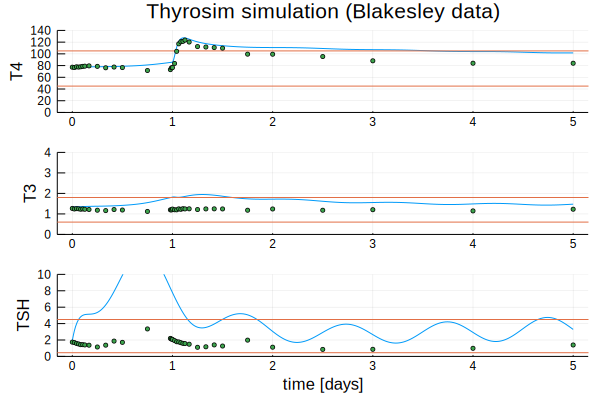

In [5]:
plot_blakesley(sol, "400")

## Optimize blakesley error

Blakesley dataset is used to fit TSH and T4 errors. Since T4 is in the range of $10^2$ and TSH is in $10^0$, we divide T4 error by 100 to adjust for this difference. 

Read about closures [here](http://julianlsolvers.github.io/Optim.jl/latest/#user/tipsandtricks/#_top). 

In [76]:
function fit_blakesley()
    # initialize initial guess and fitting index
    fitting_index = [30; 31; 49; 50; 51; 52; 53; 54]
    initial_guess = [101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]

    # import data
    my_time, my400_data, my450_data, my600_data = blakesley_data()
    data_400 = [my400_data[:, 1] my400_data[:, 3]] # [T4 TSH]
    data_450 = [my450_data[:, 1] my450_data[:, 3]]
    data_600 = [my600_data[:, 1] my600_data[:, 3]]

    return optimize(p -> blakesley_objective(p, fitting_index, my_time, data_400, data_450, data_600), 
                        initial_guess, NelderMead(), Optim.Options(iterations = 500))
end

fit_blakesley (generic function with 1 method)

In [77]:
#main objective function for T4 and TSH error
function blakesley_objective(p_being_optimized, fitting_index, time, my400_data, my450_data, my600_data)
    ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
    p[fitting_index] .= p_being_optimized
    tspan = (0.0, 120.0)
    cbk   = ContinuousCallback(condition, add_dose!); 
    
    # solve different ODE problems for varying doses
    p_400 = p_450 = p_600 = copy(p)
    p_400[55] = 400.0 / 777.0
    p_450[55] = 450.0 / 777.0
    p_600[55] = 600.0 / 777.0
    prob_400 = ODEProblem(thyrosim,ic,tspan,p_400,callback=cbk)
    prob_450 = ODEProblem(thyrosim,ic,tspan,p_450,callback=cbk)
    prob_600 = ODEProblem(thyrosim,ic,tspan,p_600,callback=cbk)
    sol_400 = solve(prob_400, save_idxs=[1, 7])
    sol_450 = solve(prob_450, save_idxs=[1, 7])
    sol_600 = solve(prob_600, save_idxs=[1, 7])
    
    T4_error = blakesley_t4_error(sol_400, time, my400_data, p[47]) + 
               blakesley_t4_error(sol_450, time, my450_data, p[47]) + 
               blakesley_t4_error(sol_600, time, my600_data, p[47])
    
    TSH_error = blakesley_tsh_error(sol_400, time, my400_data, p[48]) + 
                blakesley_tsh_error(sol_450, time, my400_data, p[48]) + 
                blakesley_tsh_error(sol_600, time, my400_data, p[48])
    
#     println("T4 error:", 0.01T4_error)
#     println("Tsh error:", TSH_error)
    
    return 0.01T4_error + TSH_error
end

blakesley_objective (generic function with 1 method)

In [78]:
# helper functions for calculating the error
function blakesley_tsh_error(sol, time, data, Vtsh)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[2] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 2])^2
        end
    end
    return tot_loss
end
            
function blakesley_t4_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
    end
    return tot_loss
end

blakesley_t4_error (generic function with 2 methods)

In [79]:
result = fit_blakesley()

 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.02e+02, 4.78e+01, 1.69e+00,  ...]
    Minimum:   3.298402e+01

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [1.01e+02, 4.76e+01, 4.57e+00,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   21  (vs limit Inf)
    Iterations:    500
    f(x) calls:    795


In [80]:
fitting_index = [30; 31; 49; 50; 51; 52; 53; 54]
initial_guess = [101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]

[result.minimizer initial_guess]

8×2 Array{Float64,2}:
 102.186    101.0 
  47.7887    47.64
   1.68651    4.57
   3.77407    3.9 
  13.1701    11.0 
   7.38808    5.0 
   2.64216    3.5 
  13.0526     8.0 

### Test 1 run

In [71]:
my_time, my400_data, my450_data, my600_data = blakesley_data()
fitting_index = [30; 31; 49; 50; 51; 52; 53; 54]
initial_guess = [101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]

# 1st column T4, 2nd column TSH
data_400 = [my400_data[:, 1] my400_data[:, 3]]
data_450 = [my450_data[:, 1] my450_data[:, 3]]
data_600 = [my600_data[:, 1] my600_data[:, 3]]

fitting_index = [30; 31; 49; 50; 51; 52; 53; 54]
initial_guess = [101; 47.64; 4.57; 3.9; 11.0; 5.0; 3.5; 8.0]

@show blakesley_objective(initial_guess, fitting_index, my_time, data_400, data_450, data_600)

1993.634151350383
1713.8355463965902
blakesley_objective(initial_guess, fitting_index, my_time, data_400, data_450, data_600) = 3707.469697746973


3707.469697746973

# Check optimization result by plotting

In [81]:
# check if fitting is better by plotting
p[fitting_index] = result.minimizer
prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)

# solve ODE problem
new_sol = solve(prob);

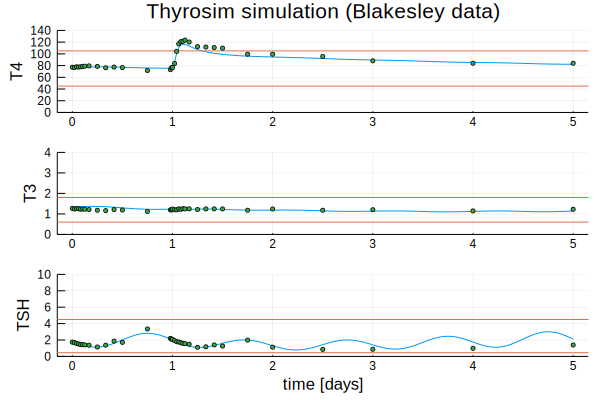

In [82]:
plot_blakesley(new_sol, "400")